In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Projects/social-media-sentimental-analysis

/content/drive/MyDrive/Projects/social-media-sentimental-analysis


In [ ]:
import re
import nltk
import pandas as pd
from pprint import pprint
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Input,LSTM, Dropout, Flatten, Dense

nltk.download("stopwords")
nltk.download('punkt_tab')
stopwords = nltk.corpus.stopwords.words("english")
le = LabelEncoder()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
data = pd.read_csv("./data/bbc-text.csv")
data.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [ ]:
data.columns

Index(['category', 'text'], dtype='object')

In [ ]:
data.shape

(2225, 2)

In [ ]:
data["category"].value_counts()

category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

<Axes: xlabel='category'>

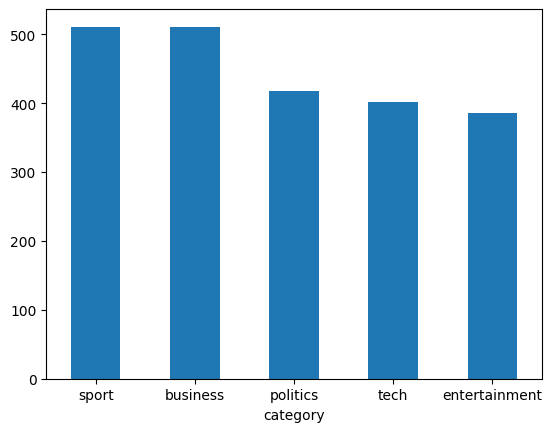

In [ ]:
data["category"].value_counts().plot.bar(rot=0)

In [ ]:
for text in data["text"].iloc[:10]:
    print(text)
    print()

tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high-

In [ ]:
data.isna().sum()

category    0
text        0
dtype: int64

In [ ]:
data.isnull().sum()

category    0
text        0
dtype: int64

# create test set

In [ ]:
train_set, test_set = train_test_split(data, test_size=0.2, stratify=data["category"], random_state=42, shuffle=True)
train_set.shape, test_set.shape

((1780, 2), (445, 2))

<Axes: xlabel='category'>

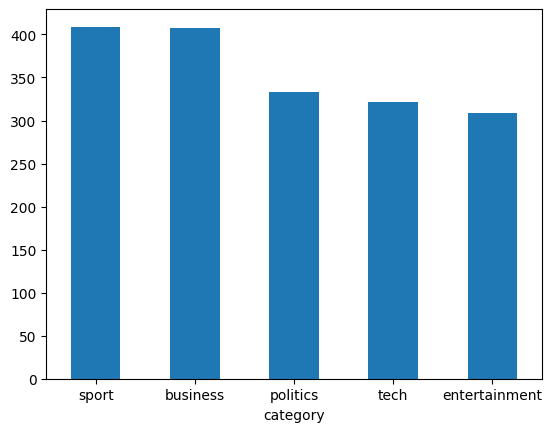

In [ ]:
train_set["category"].value_counts().plot.bar(rot=0)

<Axes: xlabel='category'>

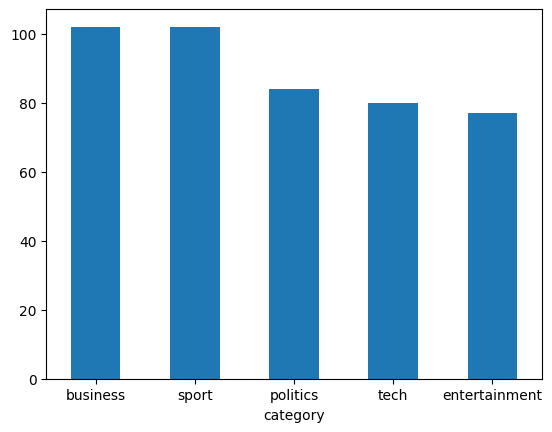

In [ ]:
test_set["category"].value_counts().plot(kind='bar', rot=0)

In [ ]:
def data_pipeline(text):
    lower = text.lower()
    remove_special_number = re.sub('[^A-Za-z\s]', '', lower)
    remove_stopwords = " ".join([word for word in remove_special_number.split() if word not in stopwords])
    # text_word_tokenize = nltk.tokenize.word_tokenize(remove_stopwords)
    return remove_stopwords

xtrain = train_set['text'].apply(data_pipeline).tolist()
ytrain = train_set['category'].tolist()

In [ ]:
print(xtrain[:3])

['share boost feudhit reliance board indian conglomerate reliance agreed share buyback counter effects power struggle controlling family buyback victory chairman mukesh ambani whose idea brother anil vicechairman said consulted buyback completely inappropriate unnecessary board hopes move reverse fall reliance shares since feud became public last month company fractious since founder dhirubhai ambani died leaving today round gone mukesh doubt said nanik rupani president indian merchants chamber bombaybased traders body company plans buy back million shares rupees apiece premium current market price', 'iaaf contest greek decision international association athletics federations appeal acquittal greek athletes kostas kenteris katerina thanou highprofile duo cleared doping offences greek athletics federation segas last month iaaf lodge appeal court arbitration sport cas suspended athletes iaaf statement said doping review board concluded decision erroneous statement continued athletes case

In [ ]:
print(ytrain[:3])

['business', 'sport', 'entertainment']


In [ ]:
max_length = (max([len(sent.split()) for sent in xtrain]))
max_length

2192

vectorizing features

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(xtrain)
sequences = tokenizer.texts_to_sequences(xtrain)
padded_sequence = pad_sequences(sequences, maxlen=max_length,padding='post', truncating='post')

In [ ]:
vocab_size = len(tokenizer.word_index)
vocab_size

27448

In [ ]:
padded_sequence[:10]

array([[ 331,  540,    1, ...,    0,    0,    0],
       [1537, 1661, 1538, ...,    0,    0,    0],
       [2828,  185, 8274, ...,    0,    0,    0],
       ...,
       [ 942,  321, 1053, ...,    0,    0,    0],
       [3724, 1026, 7390, ...,    0,    0,    0],
       [3031, 1602,  151, ...,    0,    0,    0]])

In [ ]:
ytrain_encoded = le.fit_transform(ytrain)

# Validation Data

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(padded_sequence, ytrain_encoded,
                                                 test_size=0.1, shuffle=True,
                                                 stratify=ytrain, random_state=42)

In [ ]:
X_train.shape, y_train.shape

((1602, 2192), (1602,))

In [ ]:
X_val.shape, y_val.shape

((178, 2192), (178,))

# Model

In [ ]:
model = Sequential([
    Input(shape=(X_train.shape[-1],)),
    keras.layers.Embedding(vocab_size+1, 64),
    LSTM(units=256, return_sequences=True),
    Dropout(0.2),
    LSTM(units=128, return_sequences=True),
    Dropout(0.2),
    LSTM(units=64, return_sequences=True),
    Dropout(0.2),
    LSTM(units=32, return_sequences=True),
    Dropout(0.2),
    LSTM(units=16, return_sequences=True),
    Dropout(0.2),
    LSTM(units=8, return_sequences=True),
    Dropout(0.2),
    LSTM(units=4, return_sequences=False),
    Dropout(0.2),
    #tf.keras.layers.Flatten(),
    Dense(15, activation='softmax'),
])
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 2192, 64)            │       1,756,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 2192, 256)           │         328,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 2192, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 2192, 128)           │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 2192, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 2192, 64)            │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 2192, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 2192, 32)            │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 2192, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 2192, 16)            │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 2192, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 2192, 8)             │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 2192, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 4)                   │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │              75 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,348,603 (8.96 MB)

 Trainable params: 2,348,603 (8.96 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = keras.callbacks.EarlyStopping(patience=10,
                                           verbose=0,
                                           start_from_epoch=20)

reduce_lr = keras.callbacks.ReduceLROnPlateau(patience=10,
                                              verbose=0)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=20, batch_size=64,
                    callbacks=[early_stop, reduce_lr])

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 806s 30s/step - loss: 2.6455 - val_loss: 2.5378 - learning_rate: 0.0010
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 809s 31s/step - loss: 2.5134 - val_loss: 2.4265 - learning_rate: 0.0010
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 788s 30s/step - loss: 2.4162 - val_loss: 2.3099 - learning_rate: 0.0010
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 800s 31s/step - loss: 2.2913 - val_loss: 2.2010 - learning_rate: 0.0010
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 793s 30s/step - loss: 2.1985 - val_loss: 2.1048 - learning_rate: 0.0010
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 810s 31s/step - loss: 2.1219 - val_loss: 2.0243 - learning_rate: 0.0010
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 798s 31s/step - loss: 2.0397 - val_loss: 1.9561 - learning_rate: 0.0010
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 795s 30s/step - loss: 1.9735 - val_loss: 1.9005 - learning_rate: 0.0010
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 801s 30s/step - loss: 1.9291 - val_loss: 1.8533 - learning_rate: 0.0010
Epoch 10/2